Equilibrium monomer: 0.6000000000000000, Droplet: 0.0000000000000000


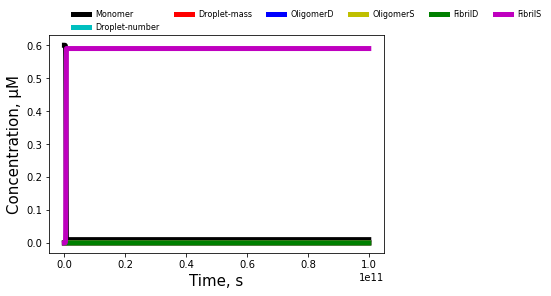

Equilibrium monomer: 0.8000000000000000, Droplet: 0.0000000000000000


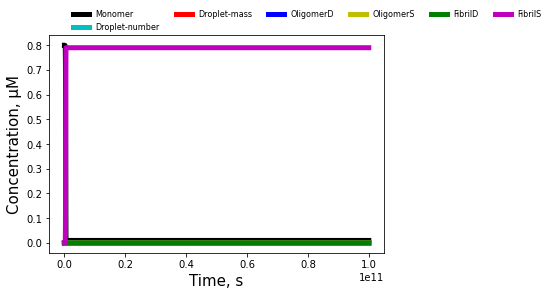

Equilibrium monomer: 1.0000000000000000, Droplet: 0.0000000000000000


KeyboardInterrupt: 

In [2]:
###### Original Python code 
# Import the required module
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import gc
from matplotlib.ticker import FormatStrFormatter
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
plt.close('all')
###########################################################################################################################
#####Here we have defined functions to get the equilibrium monomer and droplet-mass concentration as a result of LLPS
# Function definitions
def func(x, coef, nd, phi0):
    return coef * (x ** nd) * (nd + x - nd * x) - (1 - x) * (1 - x) * (phi0 - x)

def f1p(x, coef, nd, phi0):
    return coef * (x ** (nd - 1)) * (nd * (nd + x - nd * x) + x * (1 - nd)) + (1 - x) * (2 * (phi0 - x) + (1 - x))

def f2p(x, coef, nd, phi0):
    return coef * (x ** (nd - 2)) * (nd * (nd - 1) * (nd + x - nd * x) + 2 * nd * (1 - nd) * x) - 2 * (phi0 - 3 * x + 2)

def solve_equilibrium(phi_bn, phi_sn, nd, initial_concentration):
    phi0 = initial_concentration / phi_bn
    coef = (phi_bn / phi_sn) ** (nd - 1)

    # Newton-Raphson method 
    sigma = phi0 if phi0 <= 1 else 1
    tol = 1.0e-8
    for i in range(10):
        fx = func(sigma, coef, nd, phi0)
        f1px = f1p(sigma, coef, nd, phi0)
        f2px = f2p(sigma, coef, nd, phi0)

        r = 1 - fx * f2px / (2 * f1px ** 2)
        r = max(min(r, 1.2), 0.8)  # Clamp r between 0.8 and 1.2

        delta = -fx / (f1px * r)
        sigma += delta

        if abs(delta) < tol:
            break

    equilibrium_monomer = sigma * phi_bn
    droplet = (phi0 - sigma) * phi_bn
    #Apply threshold: if droplet < 10^-10, set it to 0
    droplet = droplet if droplet >= 1e-10 else 0.0
    print(f"Equilibrium monomer: {equilibrium_monomer:.16f}, Droplet: {droplet:.16f}")
    
    return equilibrium_monomer, droplet

###############################################################################################################################
#### Here we can change concentration, length of simulation, parameter of interest
global switch
for nf in [4]:  #### change the parameter of the interest 
    p0=[15, 10, 30, 15, nf, nf, 20000, 0.01, 7*10**(-5), 10**(-8), 7*10**(-5), 10**(-8), 0, 6, 6, 1, 2, 2, 1, 0] 
    ## p00[0]= droplet-intermediates dissociation rate 
    ## p00[1]=droplet dissociation rate 
    ## p0[2]=Binodal point 
    ## p00[3]= droplet nucleation size 
    ## p00[4]=fibril nucleation size 
    ## p0[5]=fibril-secondary nucleation size 
    ## p00[6]=0 
    ## p0[7]= critical_concentration 
    ## p0[8]= monomer-oligomer dissociation rate in droplet 
    ## p00[9]= monomer-fibril dissociation rate in droplet 
    ##p0[10]= monomer-oligomer dissociation rate in solution
    ## p00[11]= monomer-fibril dissociation rate in solution 
    ## p0[12]=0 
    ## p0[13]= oligomer to fibril conformational barrier in droplet
    ## p00[14]= oligomer to fibril conformational barrier in solution 
    ## p0[15]= alpha-coeficient ##
    ## p00[16]= free-energy difference between fragmentation and monomeric dissociation
    ## p00[17]= surface adsorption energy 
    ## p0[18]= 1 (1 to consider fragmentaion, 0 for no)
    ## p00[19]= 1 (1 to consider secondary nucleation, 0 for no)
    #### Change the concentration 
    yy=[0.6,0.8,1,2,4,8,10,21,31,40,50,60,70,80,90,100,200,301,400,500] ## initial monomer concentration
    n=len(yy) ## total length of discrete concentration points
    #### Change length of simulation
    tend=[1*10**11,1*10**11,1*10**11,2*10**10,2*10**10,2*10**10,2*10**10,2*10**10,2*10**9,2*10**9,1*10**8,1*10**8,1*10**8,1*10**8,1*10**8,1*10**8,1*10**8,1*10**8,1*10**8,1*10**8]
#####################################################################################################################################################################################   
    
    #Define the limitaion on fragmentation
    def Fragmentation(x,y,z):
        if y==0:
            out=0
        else:
            l= x/y
            if l > 2*z:
                out=1
            elif l >1 and l <= 2*z:
                out= l/z -1
            else:
                out=0
        return out

    # Initialize an empty DataFrame to store the time-step and the corresponding fibril-mass
    df = pd.DataFrame()
    
    # In this defined function, C_d,[n_d] are normalized by K_md*y0[0]**Nd, denoted as Kmd_norm
    def func0(t, u):
        global switch, MDm
        du = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Initial rate of change of states
        ##########################################################################################################################
        ### Initial droplet nucleation and growth terms  
        AAA= (u[0]/y0[0])**p[3]   ###### droplet nucleation normalized by K_dn*y0[0]**Nd, denoted as Kdn_norm
        AA=  p[3]*AAA
        BB=  (p[1]/p[2]*u[0] - p[1])*u[1] 
        BBB= (p[1]/p[2]*u[0] + p[0])*u[2]
        CC=  p[0]*p[3]*u[2]- p[1]*u[2]
        CCC= p[0]* u[2]
        CCCC=p[1]* u[10]
        
        ### If kinetics maximum droplet mass is greater than equilibrium droplet mass, update the maximum droplet mass value
        MDm11 = MDm1
        if (u[3]*Kdn_norm > MDm):
            MDm = u[3]*Kdn_norm
        if (MDm > MDm11):
            MDm11 = MDm
    
        ######################################################################################################################
        # Define the approximation for higher order fibril in droplets  to truncate the hierarchical dependency
        if t>0: 
            if u[0]>p[7]:
                nf1plus1= u[36]
                
            else:
                nf1plus1= u[36]*(p[2]/p[7])   
        else:
            nf1plus1= 0
            
         #####################################################################################################################
        # Define the approximation for higher order fibril in solution  to truncate the hierarchical dependency
        if t>0:
            if u[0]>p[7]:
                nf2plus1= u[27] 
            else:
                nf2plus1= u[27]*(u[0]/p[7])   
        else:
            nf2plus1= 0
        ##################################### ###################################################################################
        ## fibrilization terms in droplet phase   
        if p[19]==0:
            DDDmd= p[15]*Kfn2*u[3]*p[2]**(p[4]-1)
        else:
            DDDmd= p[15]*Kfn2*u[3]*p[2]**(p[4]-1)*(1+Cs*u[6]/MDm11)/(1+ Cs**(1/p[3])*u[6]/MDm11)                # normalized oligomer number (primary + secondary) nucleation in the droplets
        DDmd=  p[4]*DDDmd;                                                                                      # normalized oligomer mass nucleation in the droplets
        MM1md= p[15]*p[4]*p[8]*u[4]*u[3]/MDm11                                                                  # normalized oligomer disintegration into droplet-monomer
        FFmd= (p[15]*Kf2p*p[2]-p[15]*p[9])*u[5]*u[3]/MDm11 + p[15]*p[9]* u[28]* u[3]/MDm11                      # normalized growth and shrinking of the fibril in the droplets 
        MMM1md= (p[15]*Kf2p*p[2]*u[4] - p[15]*p[9]*u[28])*np.exp(-p[13])*u[3]/MDm11                             # normalized fibril nucleation from oligomer 
        
           
        if p[19]==0:
            DDD= p[15]*Kfn2*Kdn_norm*u[3]*p[2]**(p[4]-1)
        else:
            DDD= p[15]*Kfn2*Kdn_norm*u[3]*p[2]**(p[4]-1)*(1+Cs*u[6]/MDm11)/(1+ Cs**(1/p[3])*u[6]/MDm11)         # normalized oligomer number (primary + secondary) nucleation in the droplets
        FF= (p[15]*Kf2p*p[2]-p[15]*p[9])*u[5]*u[3]*Kdn_norm/MDm11 + p[15]*p[9]* u[28]* u[3]*Kdn_norm/MDm11      # Unnormalized growth and shrinking of the fibril in the droplets 
        FF1= (Kf2p*u[0]-p[11])*u[5]*(1-u[3]*Kdn_norm/MDm11) + p[11]*u[28]*(1-u[3]*Kdn_norm/MDm11)               # Unnormalized fibril (nucleated within droplets) growth by solution monomer
        MMM1=  (p[15]*Kf2p*p[2]*u[4] - p[15]*p[9]*u[28])*np.exp(-p[13])*u[3]*Kdn_norm/MDm11                     # Unnormalized fibril nucleation from oligomer (nucleated within droplets) by droplet monomer
        MMM2=  (Kf2p*u[0]*u[4] - p[11]*u[28])*np.exp(-p[14])*(1-u[3]*Kdn_norm/MDm11)                            # Unnormalized fibril nucleation from oligomer (nucleated within droplets) by solution monomer
        MMM= MMM1 + MMM2                                                                
        MM= (p[4]+1)*MMM
        MM11= p[15]*p[4]*p[8]*u[4]*(1-u[3]*Kdn_norm/MDm1)                                                       # Unnormalized oligomer disintegration into solution-monomer
        MM2= p[15]*p[8]*u[4]                                                                                    # Oligomer disintegration
        #####################################################################################################################
        ## fibrilization terms in solution phase   
        if p[19]==0:
            EEE = Kfn2*u[0]**p[4]
        else:
            EEE = Kfn2*u[0]**p[4]*(1 + Cs*u[9]/p[6] + Cs*(1-u[3]*Kdn_norm/MDm11)*u[6]/p[6])                     # Oligomer number (primary + secondary) nucleation in the solution
        EE  = p[4]*EEE;                                                                                         # Monomer loss due to oligomer nucleation in the solution
        GG  = (Kf2p*u[0]- p[11])*u[8] + p[11]*u[19];                                                            # Growth and shrinking of the fibril in the solution                                  
        NNN = p[10]*u[7]                                                                                        # Oligomer number disintegration to monomer
        NN  = p[4]*NNN                                                                                          # Oligomer-mass disintegration
        NN1 = (Kf2p*u[0]*u[7] - p[11]*u[19])*np.exp(-p[14])                                                     # Fibril nucleation from oligomer 
        NN2 = (p[4]+1)* NN1                                                                                     # Fibril mass nucleation from oligomer
        ######################################################################################################################
        ## restoring the monomer-droplet equilibrium due to monomer loss within droplets due to fibrilization within droplets
        if Kdn_norm*u[3]>0:
            MM3= (DDmd - MM1md + FFmd + MMM1md)/u[3]*u[1]
            MM4= (DDmd - MM1md + FFmd + MMM1md)/u[3]*u[2]
        else:
            MM3=0
            MM4=0
        #####################################################################################################################
        # restoring the monomer-droplet equilibrium due to monomer loss due to fibrilization in solution phase 
        sigma= u[0]/p[2]
        kdeno= p[3] + sigma - sigma*p[3]
        knum= 1 + kdeno
        con=0.1
        if u[0] >= p[2] or (u[1]>0 and u[2]/u[1]>= (1-sigma)*(1+con)):
            KK=  0
            KKK= 0
        else:
            KK= (FF1 + MMM2 - MM11 + EE -NN +GG +NN1 )/u[0]*u[1]* sigma/(1-sigma)* 1/kdeno
            KKK= (FF1 + MMM2 - MM11 + EE -NN +GG +NN1 )/u[0]*u[2]*sigma/(1-sigma)* knum/kdeno   
        #######################################################################################################################
        # set the approximation for the higher droplet size to truncate the hierarchical dependency
        if u[0]>= p[2]:
            nd2plus1=u[18]
        else:
            nd2plus1=u[18]*sigma
        ########################################################################################
        ## Considering fragmentation, Cf=0 if you do not consider fragmentation
        if p[18]==0:
            JJ1=0
            JJ2=0
        else:
            JJ1= Cf*p[11]*u[6]*Fragmentation(u[6],u[5], p[4]+1)  # fragmentation in droplets
            JJ2= Cf*p[11]*u[9]*Fragmentation(u[9],u[8], p[4]+1)  # fragmentation in solution
        #######################################################################################################################    
        ## Rate-mass equations
        du[0] = -(AA + BB - CC)*Kdn_norm - (FF1 + MMM2 - MM11) - EE + NN- GG - NN1                  
        du[1] =   AAA - CCC - KK - MM3     
        du[2]=  AAA - BBB + CCCC - KKK - MM4
        du[3] = (AA + BB - CC) - (DDmd - MM1md +FFmd +MMM1md)
        du[4]= DDD  - MM2 - MMM
        du[5] = MMM + JJ1
        du[6] = (MM + FF + FF1)
        du[7]= EEE - NNN - NN1
        du[8] = NN1 + JJ2
        du[9] = NN2 + GG 
        ######################################################################################################
        # Higher order droplets rate-mass equations and truncate high-oreder dependency
        du[10]= (p[1]/p[2]*u[0])*u[2] -(p[1]/p[2]*u[0] + p[1])*u[10] + p[1]*u[11] 
        du[11]= (p[1]/p[2]*u[0])*u[10] -(p[1]/p[2]*u[0] + p[1])*u[11] + p[1]*u[12]
        du[12]= (p[1]/p[2]*u[0])*u[11] -(p[1]/p[2]*u[0] + p[1])*u[12] + p[1]*u[13]
        du[13]= (p[1]/p[2]*u[0])*u[12] -(p[1]/p[2]*u[0] + p[1])*u[13] + p[1]*u[14]
        du[14]= (p[1]/p[2]*u[0])*u[13] -(p[1]/p[2]*u[0] + p[1])*u[14] + p[1]*u[15]
        du[15]= (p[1]/p[2]*u[0])*u[14] -(p[1]/p[2]*u[0] + p[1])*u[15] + p[1]*u[16]
        du[16]= (p[1]/p[2]*u[0])*u[15] -(p[1]/p[2]*u[0] + p[1])*u[16] + p[1]*u[17]
        du[17]= (p[1]/p[2]*u[0])*u[16] -(p[1]/p[2]*u[0] + p[1])*u[17] + p[1]*u[18]
        du[18]= (p[1]/p[2]*u[0])*u[17] -(p[1]/p[2]*u[0] + p[1])*u[18] + p[1]*nd2plus1
        #######################################################################################################
        # Higher order fibrils (in solution) rate-mass equations and truncate high-oreder dependency
        du[19]= (Kf2p*u[0]*u[7]*np.exp(-p[14]) -(Kf2p*u[0] + p[11]*np.exp(-p[14]))*u[19] + p[11]*u[20])
        du[20]= (Kf2p*u[0]*u[19] -(Kf2p*u[0] + p[11])*u[20] + p[11]*u[21])
        du[21]= (Kf2p*u[0]*u[20] -(Kf2p*u[0] + p[11])*u[21] + p[11]*u[22])
        du[22]= (Kf2p*u[0]*u[21] -(Kf2p*u[0] + p[11])*u[22] + p[11]*u[23])
        du[23]= (Kf2p*u[0]*u[22] -(Kf2p*u[0] + p[11])*u[23] + p[11]*u[24])
        du[24]= (Kf2p*u[0]*u[23] -(Kf2p*u[0] + p[11])*u[24] + p[11]*u[25])
        du[25]= (Kf2p*u[0]*u[24] -(Kf2p*u[0] + p[11])*u[25] + p[11]*u[26])
        du[26]= (Kf2p*u[0]*u[25] -(Kf2p*u[0] + p[11])*u[26] + p[11]*u[27])
        du[27]= (Kf2p*u[0]*u[26] -(Kf2p*u[0] + p[11])*u[27] + p[11]*nf2plus1)
        #######################################################################################################
        # Higher order fibrils (in droplets) rate-mass equation and truncate high-oreder dependency
        du[28]= (p[15]*Kf2p*p[2]*u[4]*np.exp(-p[14])-(p[15]*Kf2p*p[2]+ p[15]*p[11]*np.exp(-p[14]))*u[28] + p[15]*p[11]*u[29])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[4]*np.exp(-p[14]) -(Kf2p*u[0] + p[11]*np.exp(-p[14]))*u[28] + p[11]*u[29])*(1-Kdn_norm*u[3]/MDm11) 
        du[29]=(p[15]*Kf2p*p[2]*u[28]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[29] + p[15]*p[11]*u[30])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[28] -(Kf2p*u[0] + p[11])*u[29] + p[11]*u[30])*(1-Kdn_norm*u[3]/MDm11) 
        du[30]=(p[15]*Kf2p*p[2]*u[29]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[30] + p[15]*p[11]*u[31])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[29] -(Kf2p*u[0] + p[11])*u[30] + p[11]*u[31])*(1-Kdn_norm*u[3]/MDm11) 
        du[31]=(p[15]*Kf2p*p[2]*u[30]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[31] + p[15]*p[11]*u[32])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[30] -(Kf2p*u[0] + p[11])*u[31] + p[11]*u[32])*(1-Kdn_norm*u[3]/MDm11) 
        du[32]=(p[15]*Kf2p*p[2]*u[31]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[32] + p[15]*p[11]*u[33])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[31] -(Kf2p*u[0] + p[11])*u[32] + p[11]*u[33])*(1-Kdn_norm*u[3]/MDm11) 
        du[33]=(p[15]*Kf2p*p[2]*u[32]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[33] + p[15]*p[11]*u[34])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[32] -(Kf2p*u[0] + p[11])*u[33] + p[11]*u[34])*(1-Kdn_norm*u[3]/MDm11) 
        du[34]=(p[15]*Kf2p*p[2]*u[33]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[34] + p[15]*p[11]*u[35])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[33] -(Kf2p*u[0] + p[11])*u[34] + p[11]*u[35])*(1-Kdn_norm*u[3]/MDm11) 
        du[35]=(p[15]*Kf2p*p[2]*u[34]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[35] + p[15]*p[11]*u[36])*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[34] -(Kf2p*u[0] + p[11])*u[35] + p[11]*u[36])*(1-Kdn_norm*u[3]/MDm11) 
        du[36]=(p[15]*Kf2p*p[2]*u[35]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[36] + p[15]*p[11]*nf1plus1)*Kdn_norm*u[3]/MDm11 + (Kf2p*u[0]*u[35] -(Kf2p*u[0] + p[11])*u[36] + p[11]*nf1plus1)*(1-Kdn_norm*u[3]/MDm11) 
        ###########################################################################################################################################################################################################
        # We set the monomer-droplet equilibrium while there is tyhe monomer depletion in both phases due to fibrilization 
        if switch == 0  and (Kdn_norm*u[3]/MDm11 >= 0.999 or du[3]<= 0) and (u[0]+ Kdn_norm*u[3]<= y0[0]): 
             switch = 1; 
        if switch == 1 :
            if u[3] >0 :
                Kdf= du[3]/u[3]
                du[2]=Kdf*u[2] - (knum/kdeno)*u[2]*du[0]/u[0]*sigma/(1-sigma)
                du[1]=Kdf*u[1] - (1/kdeno)*u[1]*du[0]/u[0]*sigma/(1-sigma)
            else:
                du[1]=0
                du[2]=0
        ##################################################################################################
        return du
    
    def func1(t, u):
        global switch, MDm
        du = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] # Initial rate of change of states
        ##########################################################################################################################
        ### Initial droplet nucleation and growth terms  
        AAA= (u[0]/p[2])**p[3]   ###### droplet nucleation normalized by K_dn*p[2]**Nd, denoted as Kdn_norm1
        AA=  p[3]*AAA
        BB=  (p[1]/p[2]*u[0] - p[1])*u[1] 
        BBB= (p[1]/p[2]*u[0] + p[0])*u[2]
        CC=  p[0]*p[3]*u[2]- p[1]*u[2]
        CCC= p[0]* u[2]
        CCCC=p[1]* u[10]
        
        ### If kinetics maximum droplet mass is greater than equilibrium droplet mass, update the maximum droplet mass value
        MDm11 = MDm1
        if (u[3]*Kdn_norm1 > MDm):
            MDm = u[3]*Kdn_norm1
        if (MDm > MDm11):
            MDm11 = MDm
        ######################################################################################################################
        # Define the approximation for higher order fibril in droplets  to truncate the hierarchical dependency
        if t>0: 
            if u[0]>p[7]:
                nf1plus1= u[36]
                
            else:
                nf1plus1= u[36]*(p[2]/p[7])   
        else:
            nf1plus1= 0
        ######################################################################################################################
        # Define the approximation for higher order fibril in solution  to truncate the hierarchical dependency
        if t>0:
            if u[0]>p[7]:
                nf2plus1= u[27] 
            else:
                nf2plus1= u[27]*(u[0]/p[7])   
        else:
            nf2plus1= 0
        ######################################################################################################################
        ## fibrilization terms in droplet phase
        if p[19]==0:
            DDDmd= p[15]*Kfn2*u[3]*p[2]**(p[4]-1)
        else:
            DDDmd= p[15]*Kfn2*u[3]*p[2]**(p[4]-1)*(1+Cs*u[6]/MDm11)/(1+ Cs**(1/p[3])*u[6]/MDm11)                 # normalized oligomer number (primary + secondary) nucleation in the droplets
        DDmd=  p[4]*DDDmd;                                                                                       # normalized oligomer mass nucleation in the droplets
        MM1md= p[15]*p[4]*p[8]*u[4]*u[3]/MDm11                                                                   # normalized oligomer disintegration into droplet-monomer
        FFmd= (p[15]*Kf2p*p[2]-p[15]*p[9])*u[5]*u[3]/MDm11 + p[15]*p[9]* u[28]* u[3]/MDm11                       # normalized growth and shrinking of the fibril in the droplets 
        MMM1md= (p[15]*Kf2p*p[2]*u[4] - p[15]*p[9]*u[28])*np.exp(-p[13])*u[3]/MDm11                              # normalized fibril nucleation from oligomer 
        
        if p[19]==0:
            DDD= p[15]*Kfn2*Kdn_norm1*u[3]*p[2]**(p[4]-1)
        else:
            DDD= p[15]*Kfn2*Kdn_norm1*u[3]*p[2]**(p[4]-1)*(1+Cs*u[6]/MDm11)/(1+ Cs**(1/p[3])*u[6]/MDm11)         # normalized oligomer number (primary + secondary) nucleation in the droplets
        FF= (p[15]*Kf2p*p[2]-p[15]*p[9])*u[5]*u[3]*Kdn_norm1/MDm11 + p[15]*p[9]* u[28]* u[3]*Kdn_norm1/MDm11     # Unnormalized growth and shrinking of the fibril in the droplets 
        FF1= (Kf2p*u[0]-p[11])*u[5]*(1-u[3]*Kdn_norm1/MDm11) + p[11]*u[28]*(1-u[3]*Kdn_norm1/MDm11)              # Unnormalized fibril (nucleated within droplets) growth by solution monomer
        MMM1=  (p[15]*Kf2p*p[2]*u[4] - p[15]*p[9]*u[28])*np.exp(-p[13])*u[3]*Kdn_norm1/MDm11                     # Unnormalized fibril nucleation from oligomer (nucleated within droplets) by droplet monomer
        MMM2=  (Kf2p*u[0]*u[4] - p[11]*u[28])*np.exp(-p[14])*(1-u[3]*Kdn_norm1/MDm11)                            # Unnormalized fibril nucleation from oligomer (nucleated within droplets) by solution monomer
        MMM= MMM1 + MMM2                                                                
        MM= (p[4]+1)*MMM
        MM11= p[15]*p[4]*p[8]*u[4]*(1-u[3]*Kdn_norm1/MDm1)                                                       # Unnormalized oligomer disintegration into solution-monomer
        MM2= p[15]*p[8]*u[4]                                                                                     # Oligomer disintegration
        #########################################################################################################################
        ##fibrilization terms in solution phase
        if p[19]==0:
            EEE = Kfn2*u[0]**p[4]
        else:
            EEE = Kfn2*u[0]**p[4]*(1 + Cs*u[9]/p[6] + Cs*(1-u[3]*Kdn_norm1/MDm11)*u[6]/p[6])                     # Oligomer number (primary + secondary) nucleation in the solution
        EE  = p[4]*EEE;                                                                                          # Monomer loss due to oligomer nucleation in the solution
        GG  = (Kf2p*u[0]-p[11])*u[8] + p[11]*u[19];                                                              # Growth and shrinking of the fibril in the solution                                  
        NNN = p[10]*u[7]                                                                                         # Oligomer number disintegration to monomer
        NN  = p[4]*NNN                                                                                           # Oligomer-mass disintegration
        NN1 = (Kf2p*u[0]*u[7] - p[11]*u[19])*np.exp(-p[14])                                                      # Fibril nucleation from oligomer 
        NN2 = (p[4]+1)* NN1                                                                                      # Fibril mass nucleation from oligomer
        #######################################################################################################################
        ## Restoring the monomer-droplet equilibrium due to monomer loss within droplets due to fibrilization within droplets
        if Kdn_norm1*u[3]>0:
            MM3= (DDmd - MM1md + FFmd + MMM1md)/u[3]*u[1]
            MM4= (DDmd - MM1md + FFmd + MMM1md)/u[3]*u[2]
        else:
            MM3=0
            MM4=0
        #######################################################################################################################   
        ## Restoring the monomer-droplet equilibrium due to monomer loss due to fibrilization in solution phase 
        sigma= u[0]/p[2]
        kdeno= p[3] + sigma - sigma*p[3]
        knum= 1 + kdeno
        con= 0.1
        if u[0] >= p[2] or (u[1]>0 and u[2]/u[1]>= (1-sigma)*(1+con)):
            KK= 0
            KKK= 0
        else:
            KK= (FF1 + MMM2 - MM11 + EE -NN +GG +NN1 )/u[0]*u[1]* sigma/(1-sigma)* 1/kdeno
            KKK= (FF1 + MMM2 - MM11 + EE -NN +GG +NN1 )/u[0]*u[2]*sigma/(1-sigma)* knum/kdeno   
        ########################################################################################
        # Set the approximation for the higher droplet size to truncate the hierarchical dependency
        if u[0]>= p[2]:
            nd2plus1= u[18] 
        else:
            nd2plus1= u[18]* sigma
        ########################################################################################
        ## Considering fragmentation, Cf=0 if you do not consider fragmentation
        if p[18]==0:
            JJ1=0
            JJ2=0
        else:
            JJ1= Cf*p[11]*u[6]*Fragmentation(u[6],u[5], p[4]+1)  # fragmentation in droplets
            JJ2= Cf*p[11]*u[9]*Fragmentation(u[9],u[8], p[4]+1)  # fragmentation in solution
        #########################################################################################
        #Rate-mass equations
        du[0] = -(AA + BB - CC)* Kdn_norm1 - (FF1 + MMM2 - MM11) - EE + NN - GG - NN1                    
        du[1] =   AAA - CCC - KK - MM3      
        du[2]=  AAA - BBB + CCCC - KKK - MM4
        du[3] = (AA + BB - CC) - (DDmd - MM1md +FFmd + MMM1md)
        du[4]= DDD  - MM2 - MMM
        du[5] = MMM + JJ1
        du[6] = (MM + FF + FF1)
        du[7]= EEE - NNN - NN1
        du[8] = NN1 + JJ2
        du[9] = NN2 + GG 
        ##############################################################################################
        # Higher order droplets rate-mass equations and truncate high-oreder dependency
        du[10]= (p[1]/p[2]*u[0])*u[2] -(p[1]/p[2]*u[0] + p[1])*u[10] + p[1]*u[11] 
        du[11]= (p[1]/p[2]*u[0])*u[10] -(p[1]/p[2]*u[0] + p[1])*u[11] + p[1]*u[12]
        du[12]= (p[1]/p[2]*u[0])*u[11] -(p[1]/p[2]*u[0] + p[1])*u[12] + p[1]*u[13]
        du[13]= (p[1]/p[2]*u[0])*u[12] -(p[1]/p[2]*u[0] + p[1])*u[13] + p[1]*u[14]
        du[14]= (p[1]/p[2]*u[0])*u[13] -(p[1]/p[2]*u[0] + p[1])*u[14] + p[1]*u[15]
        du[15]= (p[1]/p[2]*u[0])*u[14] -(p[1]/p[2]*u[0] + p[1])*u[15] + p[1]*u[16]
        du[16]= (p[1]/p[2]*u[0])*u[15] -(p[1]/p[2]*u[0] + p[1])*u[16] + p[1]*u[17]
        du[17]= (p[1]/p[2]*u[0])*u[16] -(p[1]/p[2]*u[0] + p[1])*u[17] + p[1]*u[18]
        du[18]= (p[1]/p[2]*u[0])*u[17] -(p[1]/p[2]*u[0] + p[1])*u[18] + p[1]*nd2plus1
        ##############################################################################################
        # Higher order fibrils (in solution)rate-mass equations and truncate high-oreder dependency
        du[19]= (Kf2p*u[0]*u[7]*np.exp(-p[14]) -(Kf2p*u[0] + p[11]*np.exp(-p[14]))*u[19] + p[11]*u[20])
        du[20]= (Kf2p*u[0]*u[19] -(Kf2p*u[0] + p[11])*u[20] + p[11]*u[21])
        du[21]= (Kf2p*u[0]*u[20] -(Kf2p*u[0] + p[11])*u[21] + p[11]*u[22])
        du[22]= (Kf2p*u[0]*u[21] -(Kf2p*u[0] + p[11])*u[22] + p[11]*u[23])
        du[23]= (Kf2p*u[0]*u[22] -(Kf2p*u[0] + p[11])*u[23] + p[11]*u[24])
        du[24]= (Kf2p*u[0]*u[23] -(Kf2p*u[0] + p[11])*u[24] + p[11]*u[25])
        du[25]= (Kf2p*u[0]*u[24] -(Kf2p*u[0] + p[11])*u[25] + p[11]*u[26])
        du[26]= (Kf2p*u[0]*u[25] -(Kf2p*u[0] + p[11])*u[26] + p[11]*u[27])
        du[27]= (Kf2p*u[0]*u[26] -(Kf2p*u[0] + p[11])*u[27] + p[11]*nf2plus1)
        ###############################################################################################
        # Higher order fibrils (in droplets) rate-mass equation and truncate high-oreder dependency
        du[28]= (p[15]*Kf2p*p[2]*u[4]*np.exp(-p[14])-(p[15]*Kf2p*p[2]+ p[15]*p[11]*np.exp(-p[14]))*u[28] + p[15]*p[11]*u[29])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[4]*np.exp(-p[14]) -(Kf2p*u[0] + p[11]*np.exp(-p[14]))*u[28] + p[11]*u[29])*(1-Kdn_norm1*u[3]/MDm11) 
        du[29]=(p[15]*Kf2p*p[2]*u[28]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[29] + p[15]*p[11]*u[30])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[28] -(Kf2p*u[0] + p[11])*u[29] + p[11]*u[30])*(1-Kdn_norm1*u[3]/MDm11) 
        du[30]=(p[15]*Kf2p*p[2]*u[29]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[30] + p[15]*p[11]*u[31])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[29] -(Kf2p*u[0] + p[11])*u[30] + p[11]*u[31])*(1-Kdn_norm1*u[3]/MDm11) 
        du[31]=(p[15]*Kf2p*p[2]*u[30]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[31] + p[15]*p[11]*u[32])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[30] -(Kf2p*u[0] + p[11])*u[31] + p[11]*u[32])*(1-Kdn_norm1*u[3]/MDm11) 
        du[32]=(p[15]*Kf2p*p[2]*u[31]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[32] + p[15]*p[11]*u[33])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[31] -(Kf2p*u[0] + p[11])*u[32] + p[11]*u[33])*(1-Kdn_norm1*u[3]/MDm11) 
        du[33]=(p[15]*Kf2p*p[2]*u[32]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[33] + p[15]*p[11]*u[34])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[32] -(Kf2p*u[0] + p[11])*u[33] + p[11]*u[34])*(1-Kdn_norm1*u[3]/MDm11) 
        du[34]=(p[15]*Kf2p*p[2]*u[33]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[34] + p[15]*p[11]*u[35])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[33] -(Kf2p*u[0] + p[11])*u[34] + p[11]*u[35])*(1-Kdn_norm1*u[3]/MDm11) 
        du[35]=(p[15]*Kf2p*p[2]*u[34]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[35] + p[15]*p[11]*u[36])*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[34] -(Kf2p*u[0] + p[11])*u[35] + p[11]*u[36])*(1-Kdn_norm1*u[3]/MDm11) 
        du[36]=(p[15]*Kf2p*p[2]*u[35]-(p[15]*Kf2p*p[2]+ p[15]*p[11])*u[36] + p[15]*p[11]*nf1plus1)*Kdn_norm1*u[3]/MDm11 + (Kf2p*u[0]*u[35] -(Kf2p*u[0] + p[11])*u[36] + p[11]*nf1plus1)*(1-Kdn_norm1*u[3]/MDm11) 
        ###########################################################################################################################################################################################################
        # We set up here that the change in droplet-number concentration is in accordance with the change in droplet-mass concentration.  
        if switch == 0 and (Kdn_norm1*u[3]/MDm11 >= 0.999 or du[3]<= 0) and (u[0]+ Kdn_norm1*u[3]<= y0[0]): 
            switch = 1; 
        if switch == 1 :
            if u[3] >0:
                Kdf= du[3]/u[3]
                du[2]=Kdf*u[2] - (knum/kdeno)*u[2]*du[0]/u[0]*sigma/(1-sigma)
                du[1]=Kdf*u[1] - (1/kdeno)*u[1]*du[0]/u[0]*sigma/(1-sigma)
            else:
                du[1]=0
                du[2]=0
        ####################################################################################################################
        return du
    
    for i in range(n):
        y0=[yy[i],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]      # chose the initial condition
        p= p0                                               # p=p0
        switch=0
        Kdp= float(f"{p[1]/p[2]:.5e}")                      # monomer-droplet association rate 
        Kdn= float(f"{Kdp*(Kdp/p[0])**(p[3]-2):.5e}")       # droplet nucleation rate
        Kf2p= float(f"{p[11]/p[7]:.5e}")                    # monomer-fibril association rate in the solution
        Kfn2= float(f"{(Kf2p*(Kf2p/p[10])**(p[4]-2)):.5e}") # oligomer nucleation rate in the solution                                  
        Kdn_norm = float(f"{Kdn*y0[0]**p[3]:.5e}")          # This is a normalization factor in func0  
        Kdn_norm1= float(f"{Kdn*p[2]**p[3]:.5e}")           # This is a normalization factor in func1 
        Cs= p[19]*np.exp(p[4]*p[17])
        Cf= p[18]*np.exp(-p[16])
        ##################################################################################################################      
        MDm = float(f"{solve_equilibrium(p[2], p[2]*p[0]/p[1], p[3], y0[0])[1]:.3e}") #calculate the maximum droplet mass
        #To prevent our equations to explode, we set up an aaproximation
        if MDm ==0:
            MDm1= y0[0]               
        else:
            MDm1= MDm
        ###################################################################################################################
        ### Introduce the solve_ivp package to solve differential equation
        ### We have considered two functions func0 and func1 for concentrations above and below the binodal point
        ### Due to complexity of our differential equations, we might change atol and rtol to excute the outcome.
        tspan = (0,tend[i])            # time span to measure the time evolution of the different states 
        if y0[0]<= p[2]:
            t_eval = np.linspace(0, tend[i],1000000)
            atol=10**(-10)
            rtol=10**(-10)
            sol =solve_ivp(func0,tspan,y0, t_eval=t_eval, method ='BDF',atol=atol, rtol=rtol)  
        else:
            t_eval = np.linspace(0, tend[i],1000000)
            atol=10**(-10)
            rtol=10**(-10)
            sol =solve_ivp(func1,tspan,y0, t_eval=t_eval, method='BDF',atol=atol, rtol=rtol)   
        ## Introduce the normalization factors from func0 and func1
        ## We have used different normalization factors in func0 and func1
        if y0[0]<= p[2]:
            norm= Kdn_norm
        else:
            norm= Kdn_norm1
        ###########################################################################################################################################
        # Plotting
        plt.plot(sol.t,sol.y[0, :],'k',linewidth = 5)      # monomer     
        plt.plot(sol.t,norm*sol.y[1, :],'c',linewidth = 5) # droplet-number
        plt.plot(sol.t,norm*sol.y[3, :],'r',linewidth = 5) # droplet-mass
        plt.plot(sol.t,p[4]*sol.y[4, :],'b',linewidth = 5) # oligomer-mass, originally nucleated within droplets
        plt.plot(sol.t,p[4]*sol.y[7, :],'y',linewidth = 5) # oligomer-mass, originally nucleated in the solution
        plt.plot(sol.t,sol.y[6, :],'g',linewidth = 5)      # fibril-mass, originally nucleated within droplets
        plt.plot(sol.t,sol.y[9, :],'m',linewidth = 5)      # fibril-mass, originally nucleated in the solution
        plt.ylabel('Concentration, \u03bcM',fontsize=15)
        plt.xlabel('Time, s',fontsize=15)
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        myleg = plt.legend(['Monomer','Droplet-number','Droplet-mass','OligomerD','OligomerS','FibrilD','FibrilS'],loc='upper left',prop = {'size':8}, bbox_to_anchor=(0.05,1.15), ncol=6, frameon=False )
        plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.show()
        ############################################################################################################################################
        # Make dataframe of time and fibril mass for the given discrete initial protein concentrations
        list1 = sol.t                                                                # List of time for the given concentration
        list2 = sol.y[6]+ sol.y[9]                                                   # List of fibril-mass for the given concentration
        temp_df = pd.DataFrame({f'Column{2*i+1}': list1, f'Column{2*i+2}': list2})   # Append the lists to the DataFrame as new columns
        df = pd.concat([df,temp_df],axis=1)                                          # Append the new DataFrame to the main DataFrame
        del list1, list2, sol                                                        # Clear memory of the lists
        gc.collect()
    #################################################################################################################################################
    # Convert dataframe into numpy array
    array = df.to_numpy()
    np.save(f'D_nf{nf}_test.npy', array.T)
    ##################################################################################################################################################